<a href="https://colab.research.google.com/github/leochoo/audiocnn/blob/main/notebooks/SVD_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls

README.md                    practice Jitter Plots.ipynb
SVD                          practice SVD plotting.ipynb
SVD Plots.ipynb              scripts
Untitled.ipynb               test.csv
archived                     testSVD
data                         testSVD group plotting.ipynb
praat.Collection             testSVD practice.ipynb


In [ ]:
# Initialize
from tqdm import tqdm
from time import sleep
import glob
import parselmouth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# filepath for the dataset
root = "/Users/leochoo/dev/GP2-dev/SVD"
# root = "./testSVD"

my_data_path = root + "/my_data"
healthy_path = root + "/healthy"
patho_path = root + "/pathological"

/Users/leochoo/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
def get_voice_data(_path):
    # select .wav files only
    wav_files = glob.glob(_path + "/*.wav")

    n_list = []
    tone_list = []
    syllab_list = []

    j_list = []
    s_list = []
    h_list = []

    # for wav_file in wav_files:
    for wav_file in tqdm(wav_files): # tqdm shows the progress bar
        sound = parselmouth.Sound(wav_file) # sound object from wav file
        pitch = sound.to_pitch()
        pulses = parselmouth.praat.call([sound, pitch], "To PointProcess (cc)")

        # name analysis
        name = os.path.basename(wav_file).split(".")[0]  
        
        ## tone
        if "l" in name:
            tone_list.append("l")
        elif "n" in name:
            tone_list.append("n")
        elif "h" in name:
            tone_list.append("h")

        ## syllable
        if "a" in name:
            syllab_list.append("a")
        elif "i" in name:
            syllab_list.append("i")
        elif "u" in name:
            syllab_list.append("u")
        # jitter
        jitter_local = parselmouth.praat.call(pulses, "Get jitter (local)", 0.0, 0.0, 0.0001, 0.02, 1.3) * 100

        # shimmer
        shimmer_local = parselmouth.praat.call([sound, pulses], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

        # HNR
        harmonicity = parselmouth.praat.call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
        hnr = parselmouth.praat.call(harmonicity, "Get mean", 0, 0)

        # Append to dataframe
        n_list.append(name)
        j_list.append(jitter_local)
        s_list.append(shimmer_local)
        h_list.append(hnr)


    # create dataframe
    df = pd.DataFrame({"Name":pd.Series(n_list),
                        "Type": np.nan,
                        "Tone": pd.Series(tone_list),
                        "Syllab": pd.Series(syllab_list),
                           "Jitter":pd.Series(j_list),
                           "Shimmer":pd.Series(s_list),
                           "HNR":pd.Series(h_list)})
    df["Type"]= _path.split("/")[-1] # identify type: my_data, healthy, functional etc...
    df = df.dropna()
    return df

In [ ]:
# Get Data

## control
healthy_df = get_voice_data(healthy_path)

## patho
functional_df = get_voice_data(patho_path + "/functional")
hyperfunctional_df = get_voice_data(patho_path + "/hyperfunctional")
organic_df = get_voice_data(patho_path + "/organic")
psychogenic_df = get_voice_data(patho_path + "/psychogenic")

## my data
my_data_df = get_voice_data(my_data_path)

100%|██████████| 16/16 [00:03<00:00,  4.94it/s]


In [ ]:
# Combine to one dataframe
frames = [my_data_df, healthy_df, functional_df, hyperfunctional_df, organic_df, psychogenic_df]
total_df = pd.concat(frames, keys=["my_data", "healthy_df", "functional", "hyperfunctional", "organic", "psychogenic"])


In [ ]:
total_df

Name         Type Tone Syllab    Jitter   Shimmer  \
my_data     0     myd_a_h      my_data    h      a  0.222252  0.017838   
            1     myd_a_l      my_data    l      a  0.487569  0.023036   
            2     myd_a_n      my_data    n      a  0.222252  0.017838   
            3     4-1_a_l      my_data    l      a  5.058610  0.105972   
            4       4_a_n      my_data    n      a  0.467767  0.016834   
...                   ...          ...  ...    ...       ...       ...   
psychogenic 814  2577-i_n  psychogenic    n      i  0.237235  0.013785   
            815  1479-i_h  psychogenic    h      i  0.260425  0.018988   
            816   911-a_h  psychogenic    h      a  0.600121  0.021966   
            817  1058-i_n  psychogenic    n      i  0.426018  0.017449   
            818  1425-i_l  psychogenic    l      i  0.456206  0.014702   

                       HNR  
my_data     0    28.288537  
            1    21.677873  
            2    28.288537  
            3     5.959865  
            4    26.713612  
...                    ...  
psychogenic 814  32.023731  
            815  26.772784  
            816  23.163991  
            817  27.967363  
            818  26.299612  

[7794 rows x 7 columns]

In [ ]:
total_df.to_csv ("./SVD_data1.csv", index = False, header=True)


NameError: name 'df' is not defined

In [ ]:
# Melt data
dd = pd.melt(total_df, id_vars=["Type", "Tone"], value_vars=["Jitter"], value_name="%")
display(dd)

,Type,Tone,variable,%
0,my_data,h,Jitter,0.222252
1,my_data,l,Jitter,0.487569
2,my_data,n,Jitter,0.222252
3,my_data,l,Jitter,5.058610
4,my_data,n,Jitter,0.467767
...,...,...,...,...
7789,psychogenic,n,Jitter,0.237235
7790,psychogenic,h,Jitter,0.260425
7791,psychogenic,h,Jitter,0.600121
7792,psychogenic,n,Jitter,0.426018


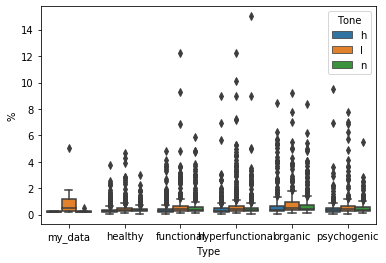

In [ ]:
# Graph Jitter l/n/h tones

sns.boxplot(x="Type", y="%", data=dd, hue="Tone")

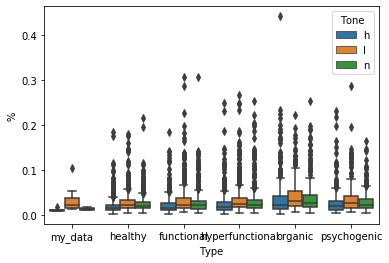

In [ ]:
# Graph Shimmer
dd = pd.melt(total_df, id_vars=["Type", "Tone"], value_vars=["Shimmer"], value_name="%")

sns.boxplot(x="Type", y="%", data=dd, hue="Tone")

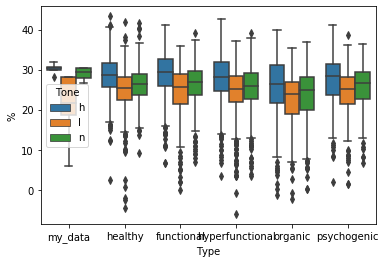

In [ ]:
# Graph HNR
dd = pd.melt(total_df, id_vars=["Type", "Tone"], value_vars=["HNR"], value_name="%")

sns.boxplot(x="Type", y="%", data=dd, hue="Tone")

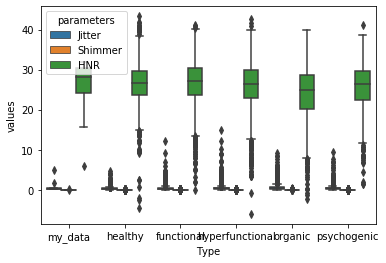

In [ ]:
# Graph jitter, shimmer, hnr for all types

dd = pd.melt(total_df, id_vars=["Type"], var_name="parameters", value_vars=["Jitter","Shimmer","HNR"], value_name="values")

sns.boxplot(x="Type", y="values", data=dd, hue="parameters")

# Now graphing all scenarios

# Jitter

## Simple Tone comparisons on all vowels

## Simple Vowel Comparisons on all tones

## Tone comparisons on the same vowel
* /a/ - l,n,h
* /i/ - l,n,h
* /u/ - l,n,h
## Vowel comparison over the same tone
* l - a,i,u
* n - a,i,u
* h - a,i,u

# Shimmer
# HNR

repeat the above?

In [ ]:
# function to generate graph based on one fixed tone or syllable
def generate_plots_by_type(_variable, _tone="", _syllab=""):
    global total_df
    if _syllab != "": #syllab fixed, tone comparison
        df = total_df.loc[total_df.Syllab == _syllab]
        dd = pd.melt(df, id_vars=["Type", "Tone"], value_vars=[_variable], value_name=_variable)
        sns.boxplot(x="Type", y=_variable, data=dd, hue="Tone", palette="Set2").set_title(_variable + " /" + _syllab + "/")
        plt.show()
    elif _tone != "": # tone fixed, syllab comparison
        df = total_df.loc[total_df.Tone == _tone]
        dd = pd.melt(df, id_vars=["Type", "Syllab"], value_vars=[_variable], value_name=_variable)
        sns.boxplot(x="Type", y=_variable, data=dd, hue="Syllab", palette="Set3").set_title(_variable + " " + _tone)
        plt.show()
    else:
        # show all simple comparisons
        dd = pd.melt(total_df, id_vars=["Type", "Tone"], value_vars=[_variable], value_name=_variable)
        sns.boxplot(x="Type", y=_variable, data=dd, hue="Tone", palette="Set2").set_title(_variable + " Tones")
        plt.show()
        dd = pd.melt(total_df, id_vars=["Type", "Syllab"], value_vars=[_variable], value_name=_variable)
        sns.boxplot(x="Type", y=_variable, data=dd, hue="Syllab", palette="Set3").set_title(_variable + " Syllables")
        plt.show()

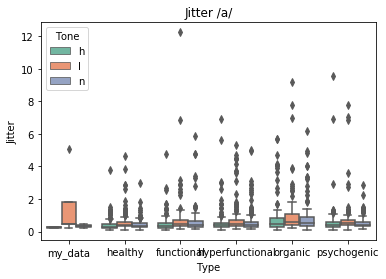

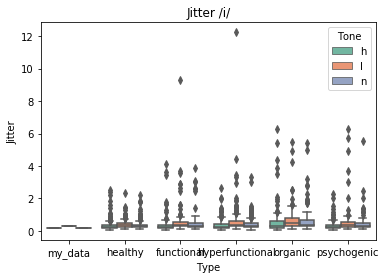

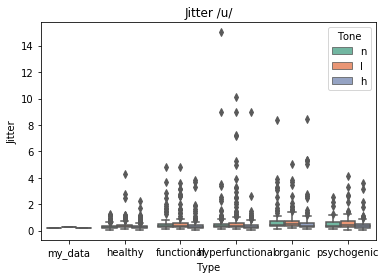

In [ ]:
# /a/
generate_plots_by_type("Jitter", _syllab="a")
# /i/
generate_plots_by_type("Jitter", _syllab="i")
# /u/
generate_plots_by_type("Jitter", _syllab="u")

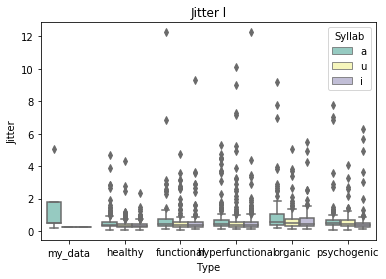

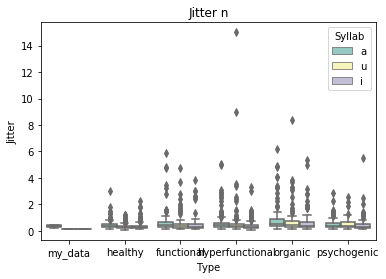

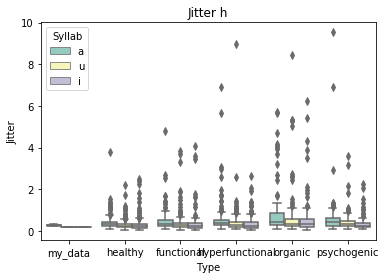

In [ ]:
# l
generate_plots_by_type("Jitter", _tone="l")
# n
generate_plots_by_type("Jitter", _tone="n")
# h
generate_plots_by_type("Jitter", _tone="h")

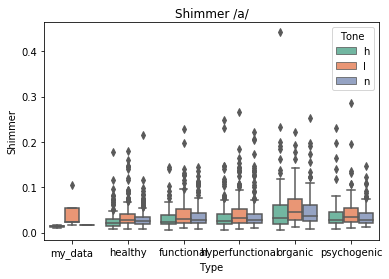

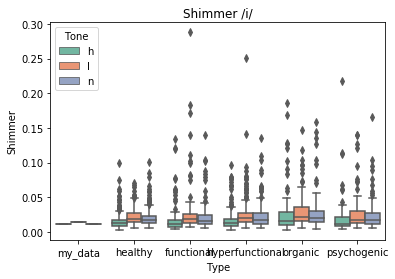

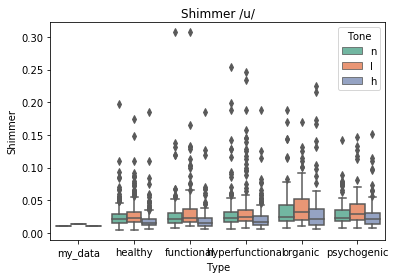

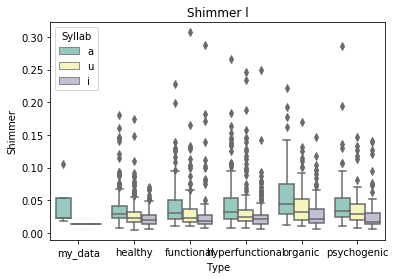

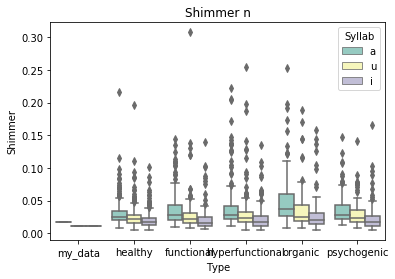

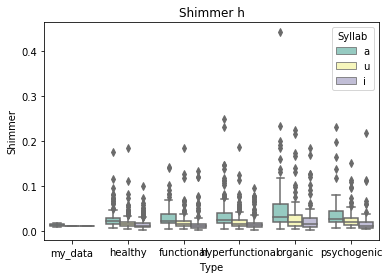

In [ ]:
# /a/
generate_plots_by_type("Shimmer", _syllab="a")
# /i/
generate_plots_by_type("Shimmer", _syllab="i")
# /u/
generate_plots_by_type("Shimmer", _syllab="u")

# l
generate_plots_by_type("Shimmer", _tone="l")
# n
generate_plots_by_type("Shimmer", _tone="n")
# h
generate_plots_by_type("Shimmer", _tone="h")

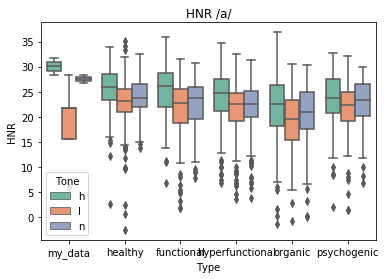

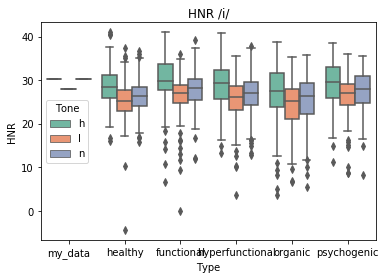

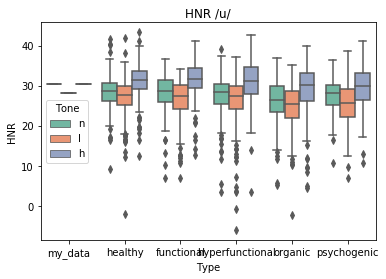

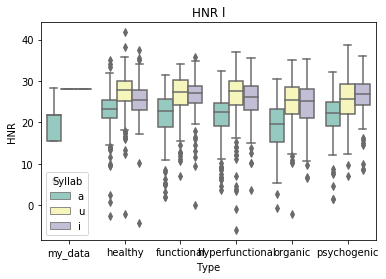

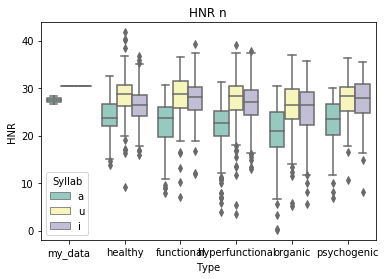

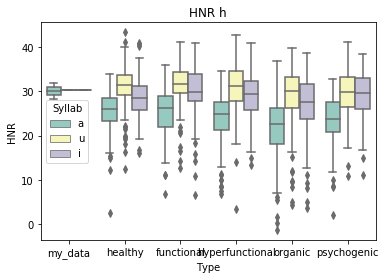

In [ ]:
# /a/
generate_plots_by_type("HNR", _syllab="a")
# /i/
generate_plots_by_type("HNR", _syllab="i")
# /u/
generate_plots_by_type("HNR", _syllab="u")

# l
generate_plots_by_type("HNR", _tone="l")
# n
generate_plots_by_type("HNR", _tone="n")
# h
generate_plots_by_type("HNR", _tone="h")

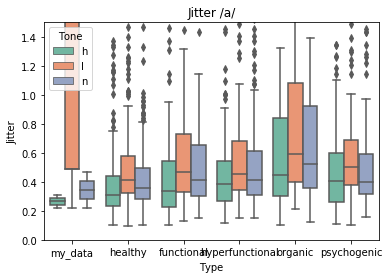

In [ ]:
# focusing on certain plots
# /a/
plt.ylim(0,1.5)
generate_plots_by_type("Jitter", _syllab="a")


,Type,Tone,variable,%
0,my_data,h,Jitter,0.222252
1,my_data,l,Jitter,0.487569
2,my_data,n,Jitter,0.222252
3,my_data,l,Jitter,5.058610
4,my_data,n,Jitter,0.467767
...,...,...,...,...
7789,psychogenic,n,Jitter,0.237235
7790,psychogenic,h,Jitter,0.260425
7791,psychogenic,h,Jitter,0.600121
7792,psychogenic,n,Jitter,0.426018


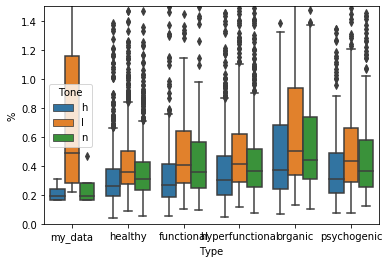

In [ ]:
# Graph Jitter l/n/h tones
# Melt data
dd = pd.melt(total_df, id_vars=["Type", "Tone"], value_vars=["Jitter"], value_name="%")
display(dd)
plt.ylim(0,1.5)
sns.boxplot(x="Type", y="%", data=dd, hue="Tone")

In [ ]:
# Melt data
dd = pd.melt(total_df, id_vars=["Type"], value_vars=["Jitter"], value_name="%")
display(dd)

,Type,variable,%
0,my_data,Jitter,0.222252
1,my_data,Jitter,0.487569
2,my_data,Jitter,0.222252
3,my_data,Jitter,5.058610
4,my_data,Jitter,0.467767
...,...,...,...
7789,psychogenic,Jitter,0.237235
7790,psychogenic,Jitter,0.260425
7791,psychogenic,Jitter,0.600121
7792,psychogenic,Jitter,0.426018
